In [117]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data

In [3]:
import deeptriplet.models
import deeptriplet.datasets

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
1


## Load GrabCut dataset

In [112]:
valset = deeptriplet.datasets.PascalDataset(pascal_root="/scratch/yardima/datasets/voc12/VOCdevkit/VOC2012",
                                            split_file="/home/yardima/Python/experiments/pascal_split/val_obj.txt",
                                            normalize_imagenet=True,
                                            augment=False,
                                            pad_zeros=True,
                                            downsample_label=1)

valloader = data.DataLoader(valset,
                                batch_size=1,
                                num_workers=2,
                                shuffle=True)

trainset = deeptriplet.datasets.PascalDataset(pascal_root="/scratch/yardima/datasets/voc12/VOCdevkit/VOC2012",
                        split_file="/home/yardima/Python/experiments/pascal_split/train_obj.txt",
                        normalize_imagenet=True,
                        augment=True,
                        pad_zeros=True,
                        downsample_label=8,
                        scale_low=0.8,
                        scale_high=1.2)

trainloader = data.DataLoader(trainset,
                                batch_size=10,
                                num_workers=4,
                                shuffle=True)

## Load trained embedding model

In [10]:
model_path_random = "/srv/glusterfs/yardima/runs/deeplabv2/lfov-triplet/run_8/models/class-vgg-pascal_epoch-49.pth"

In [11]:
d1 = torch.load(model_path_random, map_location=lambda storage, loc: storage)

In [13]:
net = deeptriplet.models.DeepLab_VGG(n_classes=45)
net = net.cuda()
net.load_state_dict(d1)

In [14]:
net = net.eval().cuda();

## t-SNE samples

In [21]:
import sklearn.manifold
import skimage.transform
import scipy.ndimage.morphology as morph
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
skimage.transform.resize()

In [24]:
def _fast_hist(label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask],
            minlength=n_class ** 2,
        ).reshape(n_class, n_class)
        return hist

In [60]:
def run_clicks(embeddings, labels, clicks, flat=True):
    dim1, dim2 = labels.squeeze().shape
    edim1, edim2, _ = embeddings.squeeze().shape

    if not flat:
        clicks_e = np.array([int(round(c[0] / 8.)) * edim2 + int(round(c[1] / 8.)) for c in clicks], dtype=np.int32)
        clicks = np.array([c[0] * dim2 + c[1] for c in clicks], dtype=np.int32)

        embeddings = embeddings.reshape(edim1 * edim2, -1)
        labels = labels.reshape(-1)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(embeddings[clicks_e,:], labels[clicks])

    pred = knn.predict(embeddings).reshape(edim1, edim2)

    pred = skimage.transform.resize(pred, output_shape=[dim1, dim2], preserve_range=True)
    pred = (pred > 0.5).astype(np.int32)
    

    pred = pred.reshape(-1)

    cf_matrix = _fast_hist(labels[valid], pred[valid], 2)

    iou = cf_matrix[1,1] / (cf_matrix[0,1] + cf_matrix[1,1] + cf_matrix[1,0])
    acc = np.sum(labels[valid] == pred[valid]) / len(valid)

    return {"pred":pred.reshape(dim1,dim2), 
            "cf":cf_matrix, 
            "iou":iou, 
            "acc":acc}

In [114]:
def simulate_clicks_x8(model, image, label, n_clicks):
    
    def run_clicks(embeddings, labels, clicks, flat=True):
        dim1, dim2 = labels.squeeze().shape
        edim1, edim2, _ = embeddings.squeeze().shape

        if not flat:
            clicks_e = np.array([int(round(c[0] / 8.)) * edim2 + int(round(c[1] / 8.)) for c in clicks], dtype=np.int32)
            clicks = np.array([c[0] * dim2 + c[1] for c in clicks], dtype=np.int32)

            embeddings = embeddings.reshape(edim1 * edim2, -1)
            labels = labels.reshape(-1)

        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(embeddings[clicks_e,:], labels[clicks])

        pred = knn.predict(embeddings).reshape(edim1, edim2)

        pred = skimage.transform.resize(pred, output_shape=[dim1, dim2], mode='constant', preserve_range=True, anti_aliasing=True)
        pred = (pred > 0.5).astype(np.int32)


        pred = pred.reshape(-1)

        cf_matrix = _fast_hist(labels[valid], pred[valid], 2)

        iou = cf_matrix[1,1] / (cf_matrix[0,1] + cf_matrix[1,1] + cf_matrix[1,0])
        acc = np.sum(labels[valid] == pred[valid]) / len(valid)

        return {"pred":pred.reshape(dim1,dim2), 
                "cf":cf_matrix, 
                "iou":iou, 
                "acc":acc}
    
    
    def pick_click(mask):
        candidates = np.transpose(np.nonzero(mask))
        return candidates[np.random.randint(low=0, high=candidates.shape[0]), :]
    
    
    if image.dim() == 3:
        image = image.unsqueeze(0)
    
    if label.dim() == 2:
        label = label.unsqueeze(0)
        
    with torch.no_grad():
        image = image.cuda()
        out = net.forward(image)
#         fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))
#         out = fc8_interp_test(out)
        
        embeddings = out.cpu().data.numpy()
        embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]) #.reshape(-1, net.n_classes)
        label = label.data.numpy()

    d_margin = 20
    d_clicks = 40
        
    label = label.squeeze()
    border = label == 255
    valid = np.nonzero((label.reshape(-1) != 255))[0]
    border = morph.binary_dilation(border, iterations=d_margin)
    

    if len(np.unique(label * (1 - border))) > 1:
        o = np.random.choice(np.sort(np.unique(label * (1 - border)))[1:])
    else:
        return []
    
    label_obj = (label == o).astype(np.int32)
    
    if not np.any((1 - label_obj) * (1 - border)) or not np.any(label_obj * (1 - border)):
        return []
    
    click_map = np.zeros(shape=border.shape, dtype=np.int32)


    p1 = pick_click((label_obj) * (1 - border))
    n1 = pick_click((1 - label_obj) * (1 - border))

    click_map[max(p1[0]-d_clicks, 0):p1[0]+d_clicks, max(p1[1]-d_clicks,0):p1[1]+d_clicks] = 1
    click_map[max(n1[0]-d_clicks, 0):n1[0]+d_clicks, max(n1[1]-d_clicks,0):n1[1]+d_clicks] = 1

    clicks = [p1, n1]
    results = []
    results.append(run_clicks(embeddings, label_obj, clicks, flat=False))

    for i in range(2, n_clicks):
        
        if not np.any((1 - click_map) * (1 - border)):
            return results
        
        c = pick_click((1 - click_map) * (1 - border))
        click_map[max(c[0]-d_clicks, 0):c[0]+d_clicks, max(c[1]-d_clicks,0):c[1]+d_clicks] = 1
        
        clicks.append(c)
        
        results.append(run_clicks(embeddings, label_obj, clicks, flat=False))
        
    return results

In [ ]:
%%time
valiter = iter(valloader)
trials = 0

n_clicks = 20
mean_acc = np.zeros(n_clicks - 1)
mean_iou = np.zeros(n_clicks - 1)

for i in range(200):
    image, label = next(valiter)
    
    for i in range(3):
        result = simulate_clicks_x8(net, image, label, n_clicks)
        
        if len(result) == n_clicks - 1:
            trials += 1
            
            mean_acc += np.array([r["acc"] for r in result])
            mean_iou += np.array([r["iou"] for r in result])
        
mean_acc /= trials
mean_iou /= trials

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x2ba690672cc0>>
Traceback (most recent call last):
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/yardima/.pye

In [103]:
results = simulate_clicks_x8(net, image, label, 20)

<IPython.core.display.Javascript object>


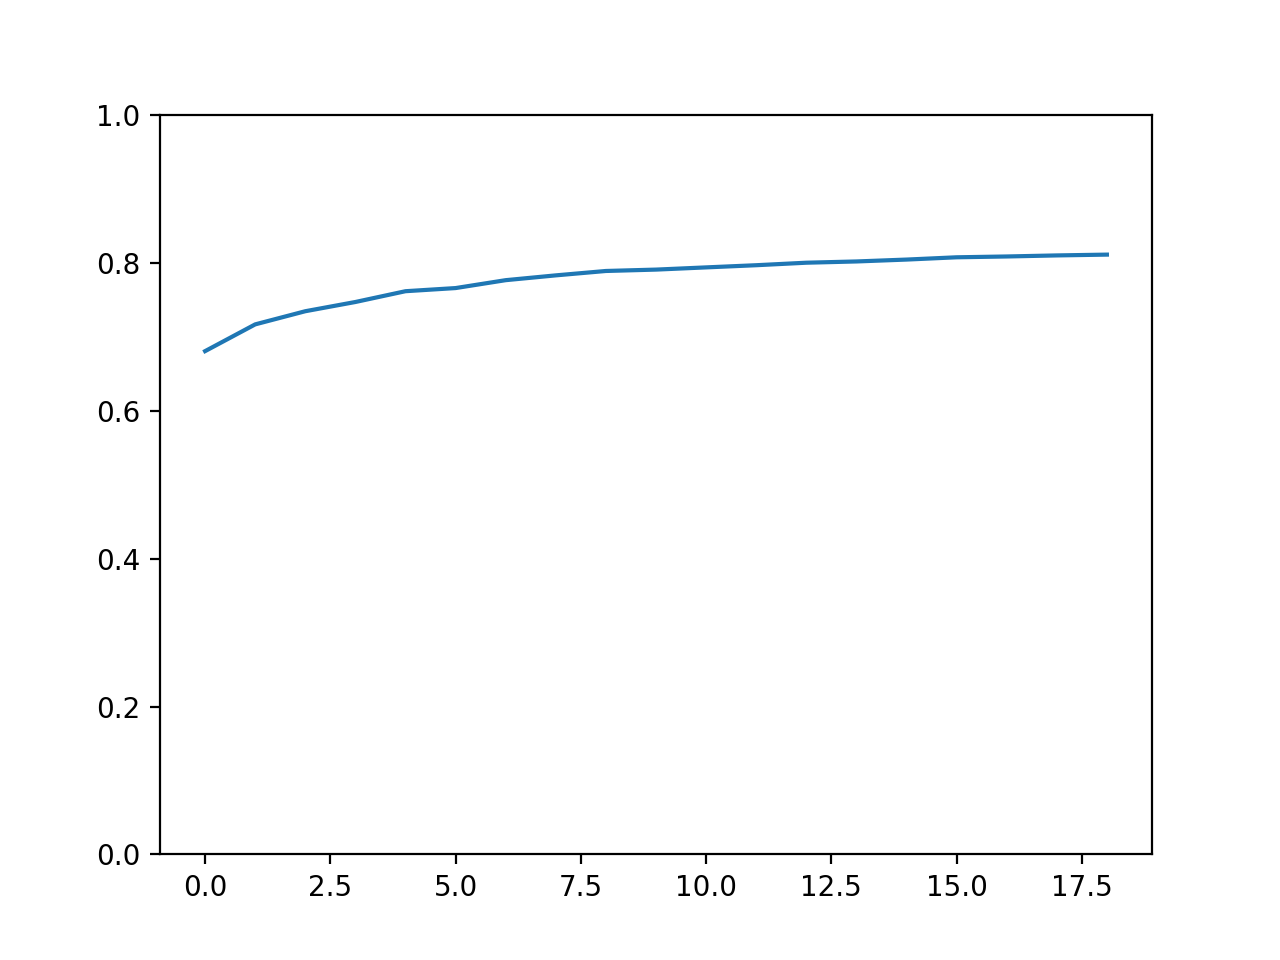

(0, 1)

In [118]:
plt.plot(mean_iou)
plt.ylim(0,1)

In [10]:
def produce_tsne(net, image, label):
    label_original = label.data.numpy().copy()
    label_original[label_original==255] = 0
    image = image.unsqueeze(0)
    label = label.unsqueeze(0)
    
    fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))

    
    with torch.no_grad():
        image = image.cuda()
        out = net.forward(image)
        #embeddings = out.cpu().data.numpy()
        embeddings = fc8_interp_test(out).cpu()
        
    embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.n_classes)
    labels = label.reshape(-1)
    
    embeddings = embeddings[labels != 255, :]
    labels = labels[labels != 255]

    
    ix = np.random.randint(low=0, high=embeddings.shape[0], size=(500,))
    embeddings_subset = embeddings[ix, :]
    labels_subset = labels[ix]
    
    X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(embeddings_subset)
    
    plt.figure(figsize=(12,4))

    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(image.squeeze(), axes=[1, 2, 0]))

    plt.subplot(1, 3, 2)
    plt.imshow(label_original.reshape(image.shape[2], image.shape[3]))

    plt.subplot(1, 3, 3)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_subset)
    
    out = fc8_interp_test(out).data.cpu().numpy()

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python

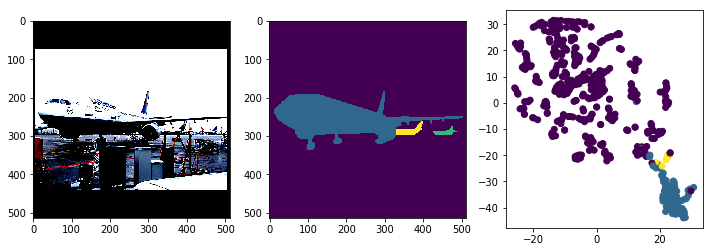

In [11]:
image, label = valset[0]
produce_tsne(net, image, label)

## Color projections

In [18]:
def rvs(dim=3):
    random_state = np.random
    H = np.eye(dim)
    D = np.ones((dim,))
    for n in range(1, dim):
        x = random_state.normal(size=(dim-n+1,))
        D[n-1] = np.sign(x[0])
        x[0] -= D[n-1]*np.sqrt((x*x).sum())
        # Householder transformation
        Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
        mat = np.eye(dim)
        mat[n-1:, n-1:] = Hx
        H = np.dot(H, mat)
        # Fix the last sign such that the determinant is 1
    D[-1] = (-1)**(1-(dim % 2))*D.prod()
    # Equivalent to np.dot(np.diag(D), H) but faster, apparently
    H = (D*H.T).T
    return H

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


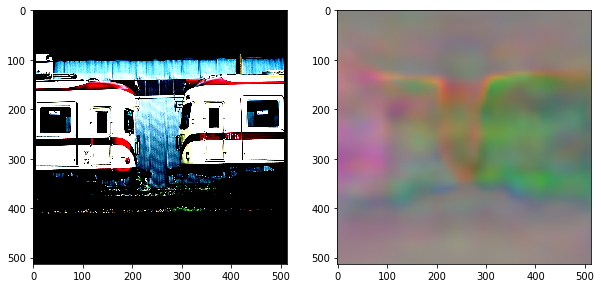

In [19]:
image, label = valset[1]

label_original = label.data.numpy().copy()
label_original[label_original==255] = 0

image = image.unsqueeze(0)
label = label.unsqueeze(0)

fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))

with torch.no_grad():
    image = image.cuda()
    out = net.forward(image)
    #embeddings = out.cpu().data.numpy()
    embeddings = fc8_interp_test(out).cpu()
    
rvo = rvs(21)[:3,:].T
embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.n_classes)
embeddings3 = np.matmul(embeddings, rvo)
embeddings3 = embeddings3.reshape(label.shape[1], label.shape[2], -1)
embeddings3
embeddings3.shape

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(image.squeeze(), axes=[1, 2, 0]))

plt.subplot(1, 2, 2)
plt.imshow(embeddings3 / 1.6 + 0.5)